<a href="https://colab.research.google.com/github/zeroxiga/ML-Data-Augmentation---SVHN/blob/main/Data%20Augmentation%20-%20SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation - SVHN
## Introduction
When training deep neural networks, the availability of data is a frequent challenge. Acquisition of additional data is often difficult, due to one or both of logistical or financial reasons. As such, methods such as fintuning, and data augmentation are common practices to address the challenge of limited data.

You have been provided with two portions of data from the Street View House Numbers
(SVHN) dataset. SVHN can be seen as a 'real world' MNIST, and although the target classes
are the same, the data within SVHN is far more diverse. The two data portions are:
1. A training set, Q3/q3 train.mat, containing 100 examples of each class (1,000 samples
total).
2. A testing set, Q3/q3 test.mat, containing 1,000 examples of each class (10,000 sam-
ples total).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import scipy.io
from skimage import data, color
from skimage.transform import resize


## Part 1: K-MNIST
Data loading. Using scipy to load the data

In [ ]:
svhn_train = scipy.io.loadmat('./Data/Q3/q3_train.mat')
svhn_test = scipy.io.loadmat('./Data/Q3/q3_test.mat')

print('Train Samples Shape:', svhn_train['train_X'].shape)
print('Train Labels Shape:', svhn_train['train_Y'].shape)

print('Test Samples Shape:', svhn_test['test_X'].shape)
print('Test Labels Shape:', svhn_test['test_Y'].shape)

Train Samples Shape: (32, 32, 3, 1000)
Train Labels Shape: (1000, 1)
Test Samples Shape: (32, 32, 3, 10000)
Test Labels Shape: (10000, 1)


       count
class       
1       17.5
2       15.3
3       12.0
4       10.5
5        9.3
6        7.3
7        8.5
8        7.2
9        6.4
10       6.0


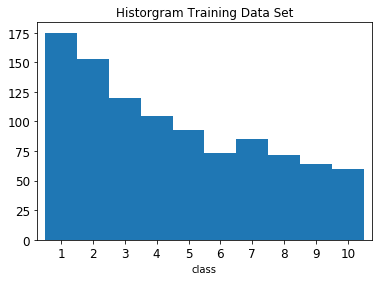

In [ ]:
# Check class distribution
df_training_count = pd.DataFrame(pd.DataFrame(svhn_train['train_Y'].tolist(), columns=['class']).groupby('class').size(), columns=['count'])
df_training_count.plot(kind='bar', title ="Historgram Training Data Set", figsize=(6, 4), legend=False, fontsize=12, rot=0, width=1)
print(round(df_training_count/df_training_count.shape[0],2))

In [ ]:
X_train = svhn_train['train_X']#.astype('float32') / 255
X_train = np.transpose(X_train, (3, 0, 1, 2))#.reshape(-1, 32, 32, 1)
Y_train = svhn_train['train_Y']
Y_train[Y_train==10] = 0
#Y_train = to_categorical(Y_train, 10)

X_test = svhn_test['test_X']#.astype('float32') / 255
X_test = np.transpose(X_test, (3, 0, 1, 2))#.reshape(-1, 32, 32, 1)
Y_test = svhn_test['test_Y']
Y_test[Y_test==10] = 0
#Y_test = to_categorical(Y_test, 10)

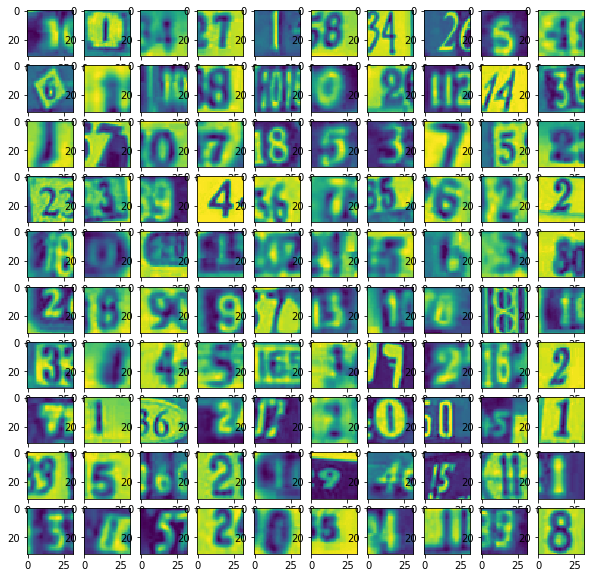

In [ ]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    #ax.imshow(resize(X_train[i,:,:,0], (28, 28), anti_aliasing=True))
    ax.imshow(X_train[i,:,:,0])

In [ ]:
def CreateModel():
    # our model, input in an image shape
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')

    # 7x7 conv
    x = layers.Conv2D(filters=8, kernel_size=(7, 7), padding='same', activation=None)(inputs)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # 5x5 conv
    x = layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # 5x5 conv
    x = layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)

    # dense layer, 256 neurons
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)

    # the output, one neuron for the cost, relu activation becuase the cost must be positive
    outputs = layers.Dense(1, activation='relu')(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    return model_cnn 

In [ ]:
model_cnn = CreateModel()
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 8)         1184      
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
spatial_dropout2d_21 (Spatia (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 16)   

### Training without Augmentation

In [ ]:
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(X_train, Y_train,
                    batch_size=16,
                    epochs=20,
                    validation_data=(X_test, Y_test), verbose=False)

In [ ]:
def eval(model_cnn, history, test, test_y):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()
    
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    w = 0.4
    pos = np.arange(0, np.shape(test_y)[0], 1)
    ax.bar(pos-w, test_y[:,0], label="Actual", width=w)
    pred = model_cnn.predict(test)
    ax.bar(pos, pred[:,0], label="Predicted", width=w)
    ax.legend()

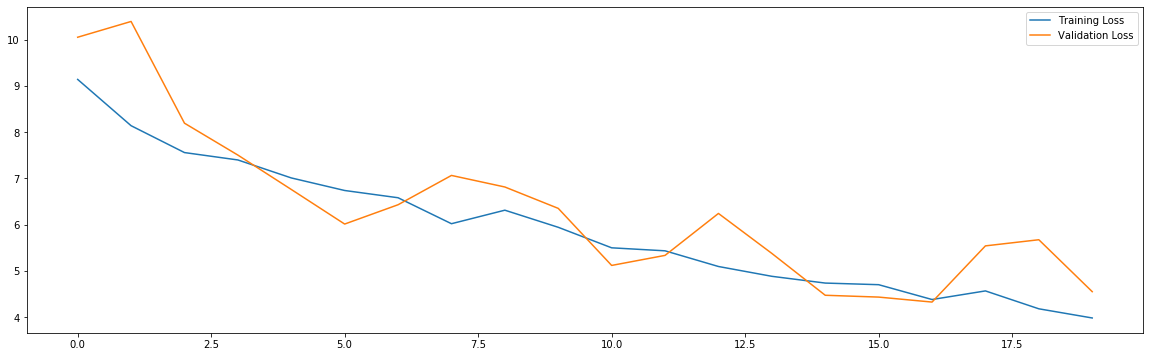

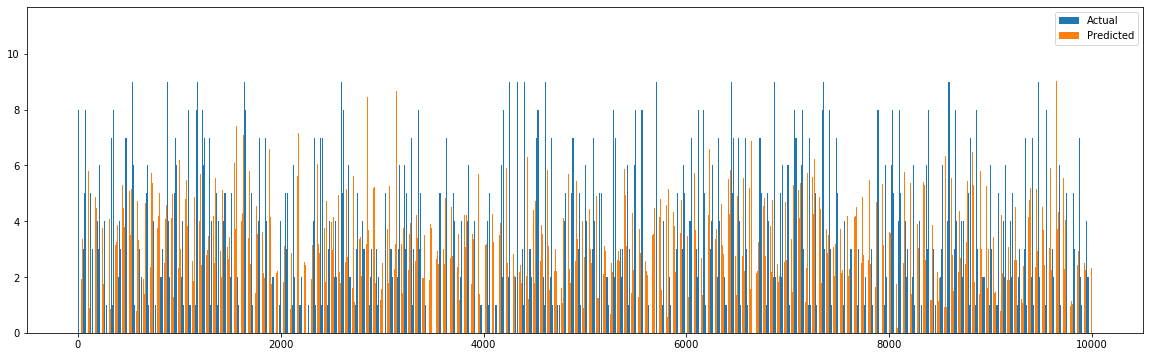

In [ ]:
eval(model_cnn, history, X_test, Y_test)

### With Augmentation
We will use the following:
* moderate translations
* small rotations
* moderate scale changes
* reflections on the X-axis

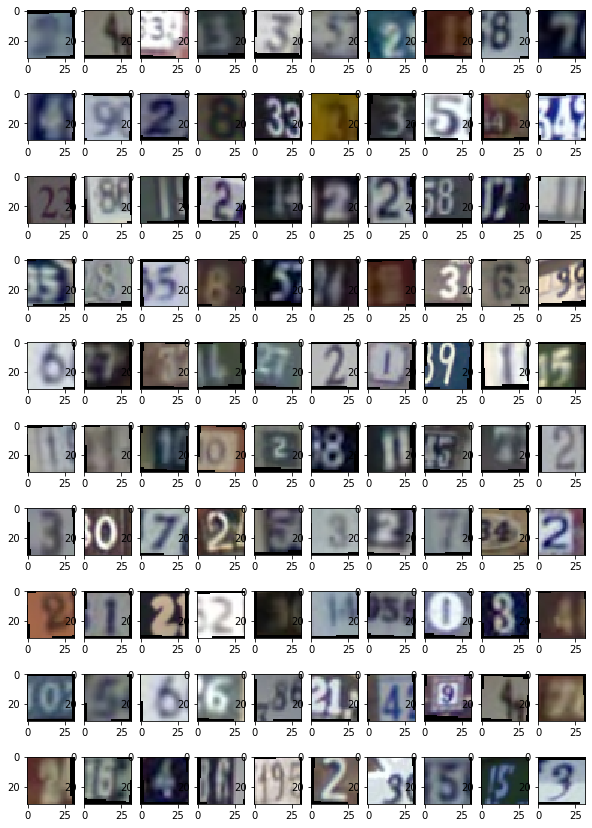

In [ ]:
datagen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for zooming
                            zoom_range=0.1,
                            # allow horizontal flips of data
                            horizontal_flip=False,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

batch = datagen.flow(X_train, Y_train, batch_size=100)

fig = plt.figure(figsize=[10, 15])
for i, img in enumerate(batch[0][0]):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(img[:,:,:].astype('uint8'))        

In [ ]:
model_cnn = CreateModel()
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(datagen.flow(X_train, Y_train, batch_size=16),
                    steps_per_epoch=450 // 16,
                    epochs=100,
                    validation_data=(X_test, Y_test), verbose=False)

  ...
    to  
  ['...']


KeyError: 'val_loss'

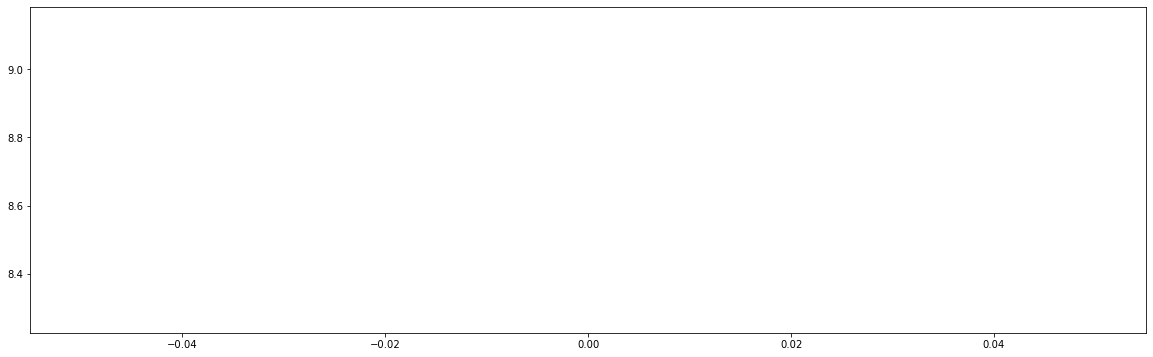

In [ ]:
eval(model_cnn, history, X_test, Y_test)

Have a quick look at the data. It's always good to make sure we have what we expect.

We need to reshape our data so such that the first index is the sample index, and convert it into a 4D structure

### The Network

This is taken from the first week 4 lecture example.

I've defined the number of training epochs here as (essentially) a global constant. Note that I've run this on my GPU desktop. You may want to scale this back for your laptop, and in particular for the network at the very bottom of this if you plan to re-run it.

In [ ]:
num_epochs = 25

def build_model(num_classes):
    # our model, input in an image shape
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    
    return model_cnn

model_cnn = build_model(10)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)    

### Train the model

We're only going to train for 10 epochs. This could easily run longer, but for the sake of speed we'll keep it short.

In [ ]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(X_train, Y_train,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(X_test, Y_test))

Train on 1000 samples, validate on 10000 samples
Epoch 1/25
 128/1000 [==>...........................] - ETA: 1s

ValueError: Can not squeeze dim[1], expected a dimension of 1, got 10 for 'metrics/accuracy/Squeeze' (op: 'Squeeze') with input shapes: [?,10].

### Evaluate the Results

Borrowing again from the week 4 lecture example, and my eval model function.

In [ ]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

We can see a few things from the above training and evaluation:
* The model probably hasn't converged fully
* Performance is fairly consistent across all classes and classes are evenly distributed

## Part 2: K-MNIST 49
We'll repeat now using the 49 class version of the data. This largely follows the above part 1.

In [ ]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

### The Model
Exactly the same as last time - that's why I created a function for it. We're just going to increase the number of classes to 49 to match the different dataset.

In [ ]:
model_cnn = build_model(49)
model_cnn.summary()

In [ ]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

In [ ]:
eval_model(model_cnn, test, test_y)

The model doesn't work that well.

We have massive class imbalance, and this doesn't help us. Let's adjust the class weights to try and compensate

### Adjusting Class Weights

We can use sklean to get the class weight for us

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())
print(class_weights)

Comparing the class weights to the histogram above, we see that these make a lot of sense. Classes that were comparitively small have a high weight, those with lots of examples have a low weight.

We can pass that info directly to the model.fit call and use that to help train the model.

In [ ]:
model_cnn = build_model(49)
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights)

In [ ]:
eval_model(model_cnn, test, test_y)

Training that network again, we see that our performance is still not that great, and has perhaps dropped a bit over what we had above. Remembering back to what we saw in week 3 with using class weights with SVMs, this is not surprising. By using the class weights we aim to improve performance for classes we have few instances of; at the possible cost of classes that we have lots of data of.

What this means is that we tend to make more errors on the really common classes, and because those classes are really common, we make more errors overall. Looking at our histogram, we see that for the really rare classes, we're still doing very badly. For the ones that we have a moderate amount of data for, we've typically improved a bit, and we've dropped a bit for some of the more common classes.

At this point it's worth pointing out that this is actually a fairly challenging dataset, with not only a decent number of classes (49), but also a lot of confusion between the classes. Telling these things apart is not that easy. We're also using a fairly simple network, which limits capacity. 

## Addendum

From above, we see a fairly substantial performance drop comapred to MATLAB. Why is this? It seems it has to do with the data representation and loss function.

MATLAB forces us to put data into a categorical data type, which gives us the one-hot vector format to match our output. Keras allows us to do this too, but also allows us to feed in the labels and use the loss function we've been using:
`keras.losses.SparseCategoricalCrossentropy(from_logits=True),`

This seems to work OK and in particular does pretty much what we'd expect for MNIST, FashionMNIST, and even KMINST-10, but is not quite as good as it should be for KMNIST-49. If we explicitly cast our data into the one-hot vector representation that we no we're going to use, we can actually get much better results, as we'll see below.

The first thing that we'll do is convert out labels, and helpfully there's a keras function for this.

In [ ]:
from tensorflow.keras.utils import to_categorical

train_y = to_categorical(kmnist_train['labels'], 49)
test_y = to_categorical(kmnist_test['labels'], 49)

From this point we'll pretty much continue as per our last attempt, so we'll use class weights again.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())

The one change is to our loss. We now have a genuine one-hot representation, so we can use the standard categorical_crossentropy.

In [ ]:
model_cnn = build_model(49)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights)

We need to modify our eval_model function slightly to deal with the different data type for our test labels.

In [ ]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    cm = confusion_matrix(gt_idx, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(gt_idx, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

The end result if that our acccuracy is much better - nothing has changed, except the loss formulation. 